# Document Extraction - _continued_

In this notebook, we will train an Amazon Comprehend custom entity recognizer so that we can detect and extract entities from a sample Hospital Discharge Summary. We will be using the [Amazon Textract Parser Library](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python) to extract the plaintext data from the document and use data science library [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to prepare training data. We will also be needing the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), and [AWS boto3 python sdk](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) libraries. We will perform two types of entity recognition with Amazon Comprehend.

- [Default entity recognition](#step1)
- [Custom entity recognition](#step2)

---

## Setup Notebook


In [2]:
import boto3
import botocore
import sagemaker
import time
import os
import json
import datetime
import io
import uuid
import pandas as pd
import numpy as np
from pytz import timezone
from PIL import Image, ImageDraw, ImageFont
import multiprocessing as mp
from pathlib import Path
from IPython.display import Image, display, HTML, JSON, IFrame
from textractcaller.t_call import call_textract, Textract_Features
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string
from trp import Document

# Document
from IPython.display import Image, display, HTML, JSON
from PIL import Image as PImage, ImageDraw


# variables
data_bucket = sagemaker.Session().default_bucket()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

os.environ["BUCKET"] = data_bucket
os.environ["REGION"] = region
role = sagemaker.get_execution_role()

print(f"SageMaker role is: {role}\nDefault SageMaker Bucket: s3://{data_bucket}")

s3=boto3.client('s3')
textract = boto3.client('textract', region_name=region)
comprehend=boto3.client('comprehend', region_name=region)


SageMaker role is: arn:aws:iam::710096454740:role/service-role/AmazonSageMaker-ExecutionRole-20220504T135260
Default SageMaker Bucket: s3://sagemaker-us-east-1-710096454740


---
# Default Entity Recognition with Amazon Comprehend <a id="step1"></a>

Amazon Comprehend can detect a pre-defined list of default entities using it's pre-trained model. Check out the [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/how-entities.html) for a full list of default entitied. In this section, we will see how we can use Amazon Comprehend's default entity recognizer to get the default entities present in the document.

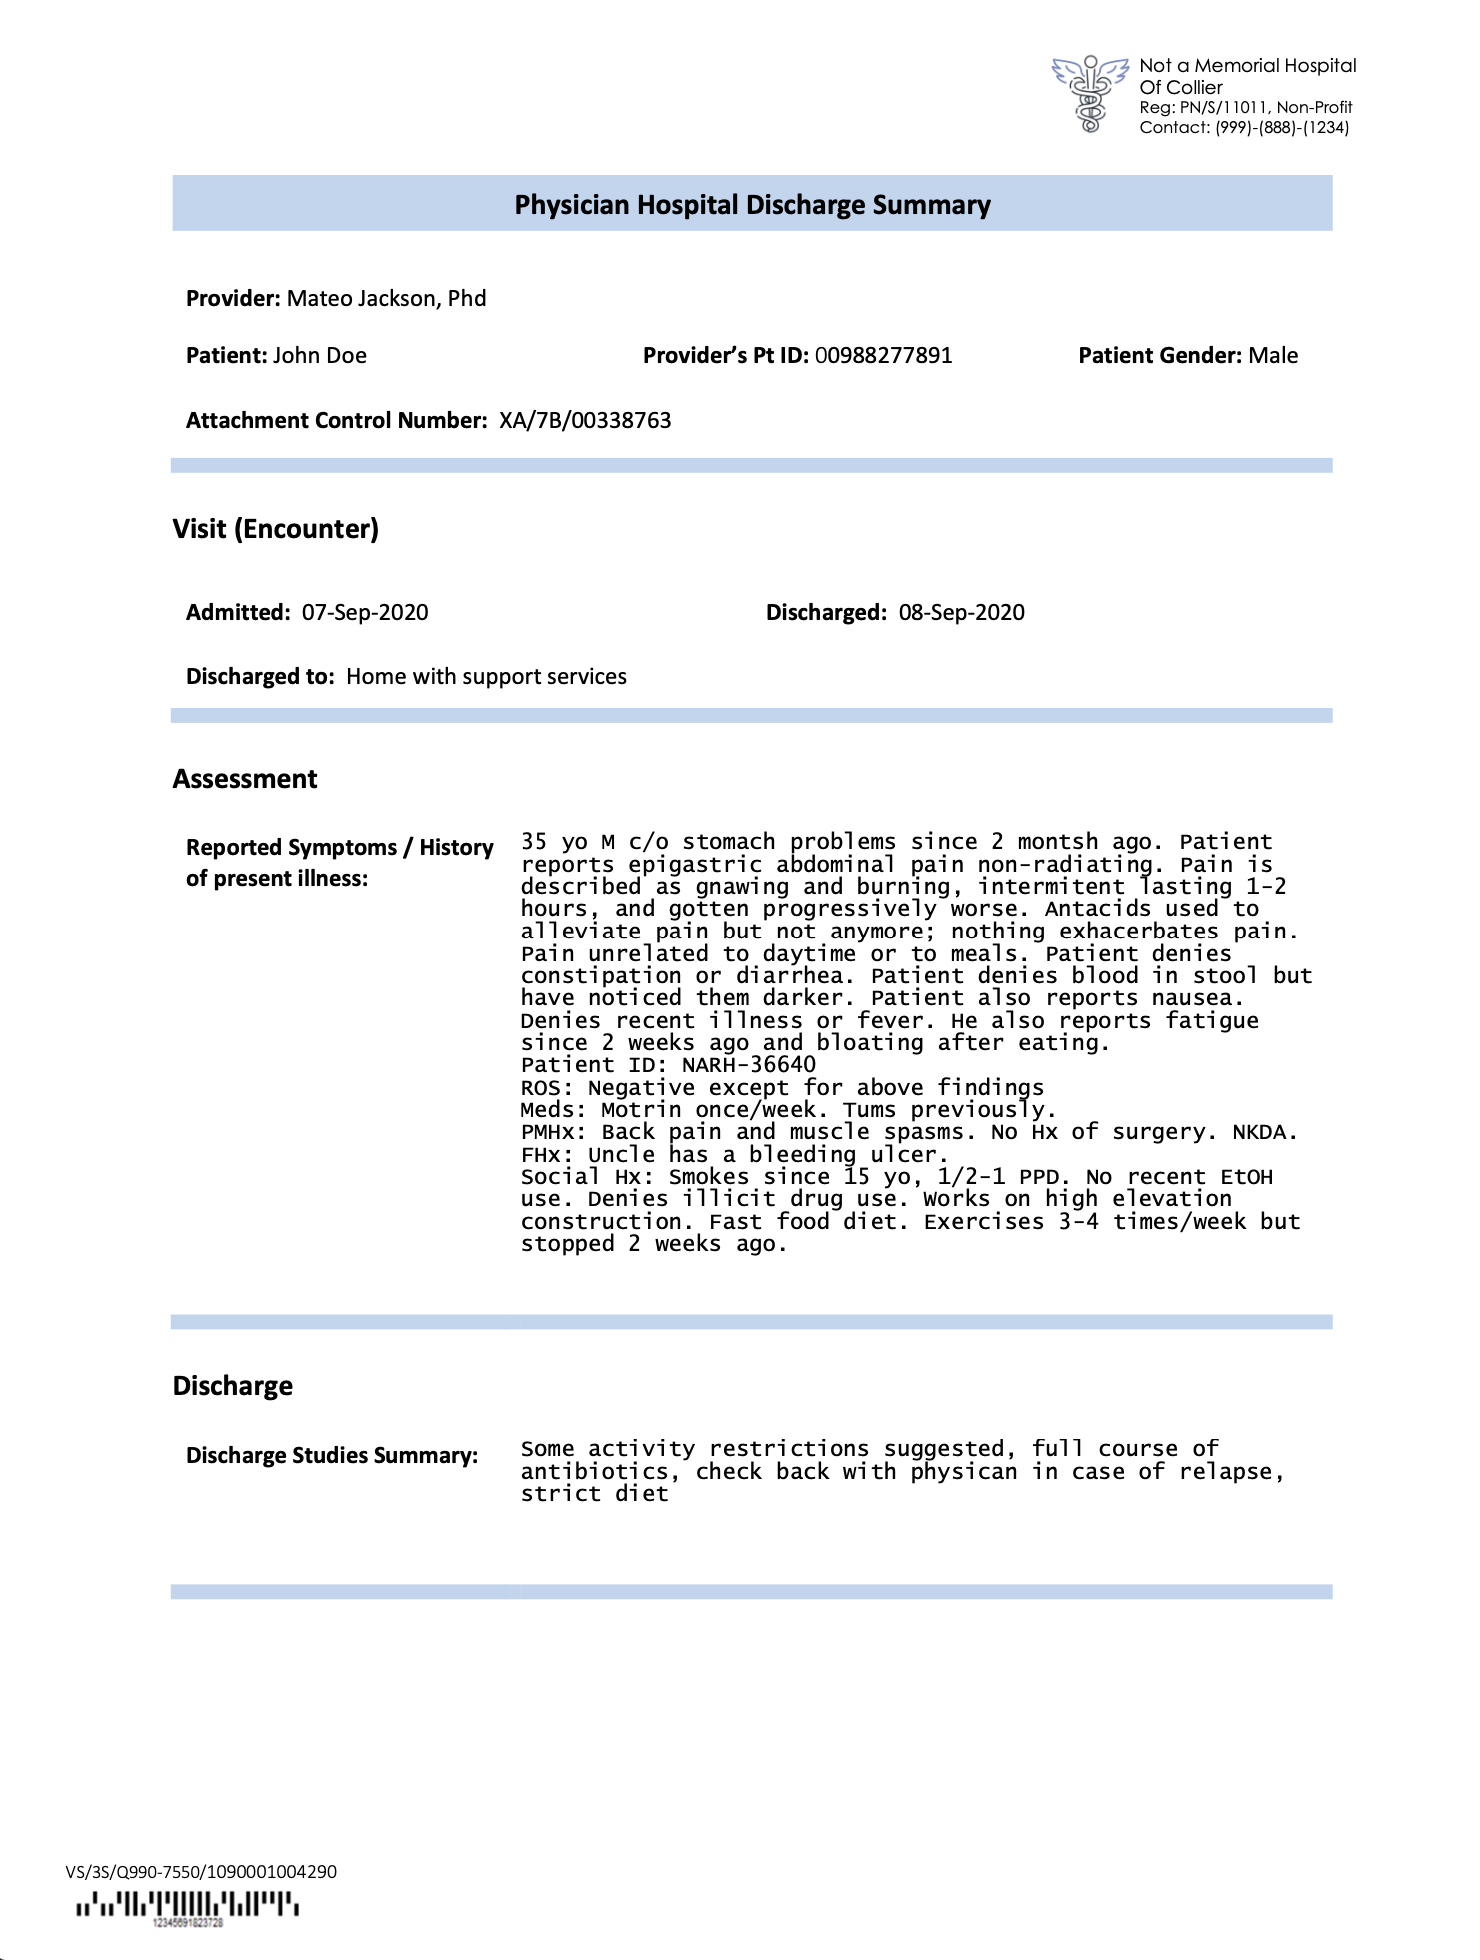

In [59]:
# document path for the discharge summary in dataset

display(Image(filename="./dataset/document_samples/discharge-summary.png", width=800, height=300))

Let's now take a look at some of the features available within Comprehend Medical. Amazon Comprehend Medical works on UTF-8 encoded plain-text, in order to get the plain-text from our scanned image file, we will use Amazon Textract OCR API `DetectDocumentText`.

In [60]:
#upload to S3
key='idp/textract/discharge_summary.png'
s3.upload_file(Filename='./dataset/document_samples/discharge-summary.png', 
               Bucket=data_bucket, 
               Key=key)

In [61]:
form_resp = textract.detect_document_text(Document={'S3Object':{"Bucket": data_bucket, "Name": key}})

In [63]:
from IPython.display import HTML as html_print
# Print text

textinfo="<span><b style='color: yellow;font-size: 24px;'>Document Text</b></span><hr/><p style='background: white; color: black; padding: 20px;'>"
text = ""
for item in form_resp["Blocks"]:
    if item["BlockType"] == "LINE":
        textinfo = f"{textinfo} {item['Text']}<br/>"
        text = text + " " + item["Text"]  # UTF-8 text
        
textinfo = f"{textinfo}</p>"
display(HTML(textinfo))

### Amazon Comprehend Medical - DetectEntities
---

Amazon Comprehend DetectEntities inspects the clinical text for a variety of medical entities and returns specific information about them such as entity category, location, and confidence score on that information. Amazon Comprehend Medical only detects medical entities in English language texts.

In [55]:
from IPython.display import HTML as html_print
comprehend_med = boto3.client(service_name='comprehendmedical')
einfo = "<span><b style='color: yellow;font-size: 24px;'>Medical Entities</b></span><table><tr><th style='text-align:left;'>Entity</th><th>Entity type</th><th>Category</th><th>Traits</th></tr>"

# Detect medical entities
cm_json_data =  comprehend_med.detect_entities_v2(Text=text)

for entity in cm_json_data["Entities"]:
    traits=[]
    if(entity["Traits"]):
        for trait in entity["Traits"]:
            traits.append(trait["Name"])
    trait_list = ",".join(traits)
    einfo = f'{einfo}<tr><td style="text-align:left;">{entity["Text"]}</td><td>{entity["Type"]}</td><td>{entity["Category"]}</td><td>{trait_list}</td></tr>'

einfo = f"{einfo}</table>"
display(HTML(einfo))

Entity,Entity type,Category,Traits
Memorial Hospital,ADDRESS,PROTECTED_HEALTH_INFORMATION,
(999)-(888)-(1234,PHONE_OR_FAX,PROTECTED_HEALTH_INFORMATION,
Mateo Jackson,NAME,PROTECTED_HEALTH_INFORMATION,
John Doe,NAME,PROTECTED_HEALTH_INFORMATION,
00988277891,ID,PROTECTED_HEALTH_INFORMATION,
00338763,ID,PROTECTED_HEALTH_INFORMATION,
07-Sep-2020,DATE,PROTECTED_HEALTH_INFORMATION,
08-Sep-2020,DATE,PROTECTED_HEALTH_INFORMATION,
35,AGE,PROTECTED_HEALTH_INFORMATION,
stomach,SYSTEM_ORGAN_SITE,ANATOMY,


### Amazon Comprehend Medical - InferICD10CM

---

InferICD10CM detects medical conditions as entities listed in a patient record and links those entities to normalized concept identifiers in the ICD-10-CM knowledge base from the Centers for Disease Control. Amazon Comprehend Medical only detects medical entities in English language texts.

In [56]:
from IPython.display import HTML as html_print

cm_json_data =  comprehend_med.infer_icd10_cm(Text=text)

info = "<span><b style='color: yellow;font-size: 24px;'>Medical coding</b></span><table><tr><th style='text-align:left;'>Description</th><th>Code</th></tr>"

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        description = icd['Description']
        code = icd["Code"]
        info = f"{info}<tr><td style='text-align:left;'>{description}</td><td>{code}</td></tr>"

info = f"{info}</table>"
display(HTML(info))


Description,Code
"Disease of stomach and duodenum, unspecified",K31.9
Other diseases of stomach and duodenum,K31.89
Unspecified symptoms and signs involving the genitourinary system,R39.9
Other specified symptoms and signs involving the digestive system and abdomen,R19.8
Other symptoms and signs involving the genitourinary system,R39.89
Epigastric pain,R10.13
Unspecified abdominal pain,R10.9
Left lower quadrant pain,R10.32
Other chronic pain,G89.29
Other acute postprocedural pain,G89.18


### Amazon Comprehend default entities - pre-trained model

---

We will now extract the (UTF-8) string text from the document above and use the Amazon Comprehend [DetectEntities](https://docs.aws.amazon.com/comprehend/latest/dg/API_DetectEntities.html) API to detect the default entities.


In [40]:
comprehend = boto3.client('comprehend')

response = comprehend.detect_entities(
                            Text=text,
                            LanguageCode='en')

In [57]:
from IPython.display import HTML as html_print

def_info = "<span><b style='color: yellow;font-size: 24px;'>Default generic entities</b></span><table><tr><th style='text-align:left;'>Entity Type</th><th>Entity Text</th></tr>"

for entity in response['Entities']:
    def_info = f'{def_info}<tr><td style="text-align:left;">{entity["Type"]}</td><td>{entity["Text"]}</td></tr>'

def_info = f"{def_info}</table>"
display(HTML(def_info))

Entity Type,Entity Text
ORGANIZATION,Memorial Hospital Of Collier
OTHER,PN/S/1 1011
OTHER,(999)-(888)
OTHER,(1234
PERSON,Mateo Jackson
PERSON,John Doe
OTHER,00988277891
OTHER,XA/7B/00338763
DATE,07-Sep-2020
DATE,08-Sep-2020



The output above shows us the default entities that Amazon Comprehend was able to detect in the document's text. However, we are interested in knowing specific entity values such as the patient name (which is denoted currently by default entity PERSON), or the patient's ID (which is denoted currently by default entity OTHER). In order to be able to do that, we will need to train an Amazon Comprehend custom entity recognizer which we will do in the following section

---
# Custom Entity Recognition with Amazon Comprehend <a id="step2"></a>

<div class="alert alert-block alert-warning"> <b style="font-size: 24px">💡 NOTE:</b> <p style="font-size: 20px">Executing the model training code block below will start a training job which can take upwards of 40 to 60 minutes to complete. In order to save time, you can skip to the "Import and existing entity recognition model" section to import a pre-trained Comprehend entity recognition model</p> </div>

## Data preparation

There are 2 different ways we can train an Amazon Comprehend  custom entity recognizer. 

- [Annotations](https://docs.aws.amazon.com/comprehend/latest/dg/cer-annotation.html)
- [Entity lists](https://docs.aws.amazon.com/comprehend/latest/dg/cer-entity-list.html)

The annotations method can often lead to more refined results for image files, PDFs, or Word documents because you train a model by submitting more accurate context as annotations along with your documents. However, the annotations method can be time-consuming and work-intensive.

For simplicity of this hands-on, we use the entity lists method, which you can only use for plain text documents. This method gives us a CSV file that should contain the plain text and its corresponding entity type, as shown in the preceding example. The entities in this file are going to be specific to our use case, here - patient name and patient ID.

For more details on how to prepare the training data for different use cases using annotations or entity lists methods, refer to [Preparing the training data.](https://docs.aws.amazon.com/comprehend/latest/dg/prep-training-data-cer.html)


Now, let's take a look at our sample document.

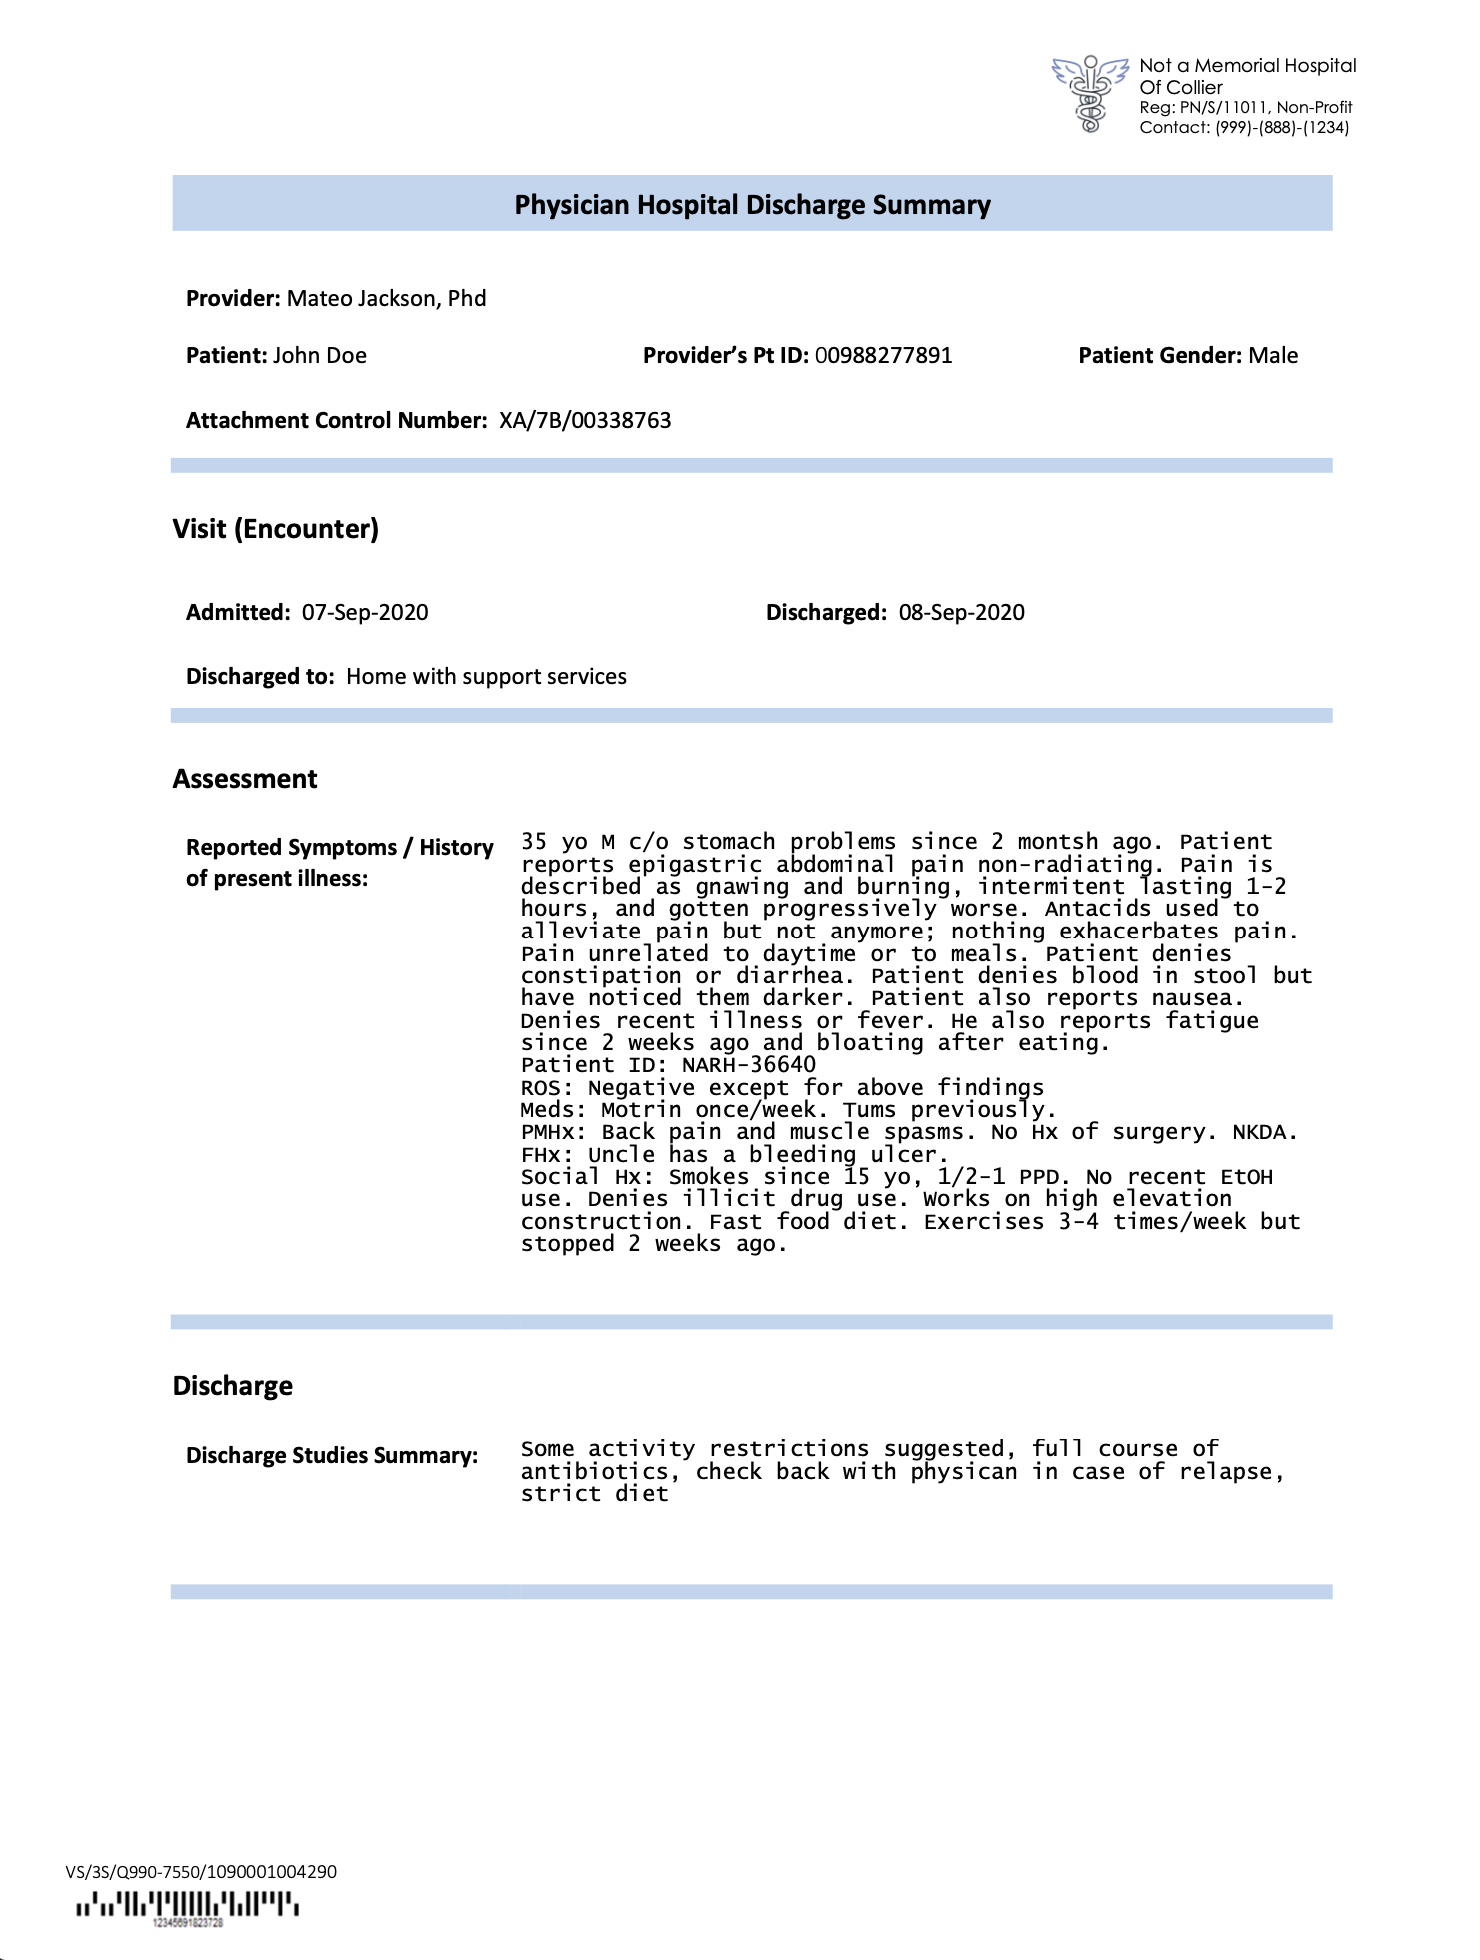

In [64]:
display(Image(filename="./dataset/document_samples/discharge-summary.png", width=900, height=400))

We would like to extract 2 entities from this document

- Patient name (`PATIENT_NAME`)
- Patient ID (`PATIENT_ID`)

Since we are going to use and Entity List with the above two entities, we need to get the sample document's content in UTF-8 encoded plain text format. This can be done by extracting the text from the document file(s) using Amazon textract.

In [ ]:
response = call_textract(input_document=f's3://{data_bucket}/idp/textract/discharge_summary.png') 
lines = get_string(textract_json=response, output_type=[Textract_Pretty_Print.LINES])
text = lines.replace("\n", " ")
text

The custom entity recognizer needs atleast 200 document samples, and 250 entity samples for each entity. For the purposes of this hands-on we have provided the augmented manifest file that provide training data for your custom model. An augmented manifest file is a labeled dataset that is produced by Amazon SageMaker Ground Truth.


---

## Training the custom entity recognizer

Let's take a look at the entity list csv file.

In [8]:
entities_df = pd.read_csv('./dataset/entity_list.csv', dtype={'Text': object})
entities = entities_df["Type"].unique().tolist()
print(f'Custom entities : {entities}')
print(f'\nTotal Custom entities: {entities_df["Type"].nunique()}')
print("\n\nTotal Sample per entity:")
entities_df['Type'].value_counts()

Custom entities : ['PATIENT_ID', 'PATIENT_NAME']

Total Custom entities: 2


Total Sample per entity:


PATIENT_ID      300
PATIENT_NAME    300
Name: Type, dtype: int64

Here, we have two types of entities in the entity list CSV file - `PATIENT_ID` and `PATIENT_NAME`. We also have 300 samples for each entity. With the minimum number of samples per entity satisfied, we can now train the custom entity recognizer model for Amazon Comprehend. Let's upload entity list CSV file and the raw text corpus of the training data to S3.

In [9]:
!aws s3 cp ./dataset/entity_list.csv s3://{data_bucket}/idp-insurance/comprehend/entity_list.csv
!aws s3 cp ./dataset/entity_training_corpus.txt s3://{data_bucket}/idp-insurance/comprehend/entity_training_corpus.txt

upload: dataset/entity_list.csv to s3://sagemaker-us-east-1-710096454740/idp-insurance/comprehend/entity_list.csv
upload: dataset/entity_training_corpus.txt to s3://sagemaker-us-east-1-710096454740/idp-insurance/comprehend/entity_training_corpus.txt


Let's initialize the variables required to start the entity recognizer training job.

In [10]:
entities_uri = f's3://{data_bucket}/idp-insurance/comprehend/entity_list.csv'
training_data_uri = f's3://{data_bucket}/idp-insurance/comprehend/entity_training_corpus.txt'

print(f'Entity List CSV File: {entities_uri}')
print(f'Training Data File: {training_data_uri}')

Entity List CSV File: s3://sagemaker-us-east-1-710096454740/idp-insurance/comprehend/entity_list.csv
Training Data File: s3://sagemaker-us-east-1-710096454740/idp-insurance/comprehend/entity_training_corpus.txt


In [11]:
# Create a custom entity recognizer
account_id = boto3.client('sts').get_caller_identity().get('Account')
id = str(datetime.datetime.now().strftime("%s"))

entity_recognizer_name = 'insurance-custom-ner-idp'
entity_recognizer_version = 'v1'
entity_recognizer_arn = ''
create_response = None
EntityTypes = []
for e in entities:
    EntityTypes.append( {'Type':e})

In [12]:
try:
    create_response = comprehend.create_entity_recognizer(
        InputDataConfig={
            'DataFormat': 'COMPREHEND_CSV',
            'EntityTypes': EntityTypes,
            'Documents': {
                'S3Uri': training_data_uri
            },
            'EntityList': {
                'S3Uri': entities_uri
            }
        },
        DataAccessRoleArn=role,
        RecognizerName=entity_recognizer_name,
        VersionName=entity_recognizer_version,
        LanguageCode='en'
    )
    
    entity_recognizer_arn = create_response['EntityRecognizerArn']
    
    print(f"Comprehend Custom entity recognizer created with ARN: {entity_recognizer_arn}")
except Exception as error:

    print(error)

Comprehend Custom entity recognizer created with ARN: arn:aws:comprehend:us-east-1:710096454740:entity-recognizer/insurance-custom-ner-idp/version/v1


Check status of the Comprehend Custom Classification Job. Alternatively, the status of the training job can also be viewed by going to the Amazon Comprehend console.
Note that the training may take ~ 30 minutes. 

Once the training job is completed move on to next step.

In [13]:
%%time
# Loop through and wait for the training to complete . Takes up to 10 mins 
from IPython.display import clear_output
import time
from datetime import datetime

jobArn = create_response['EntityRecognizerArn']

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    describe_custom_recognizer = comprehend.describe_entity_recognizer(
        EntityRecognizerArn = jobArn
    )
    status = describe_custom_recognizer["EntityRecognizerProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom document entity recognizer: {status}")
    
    if status == "TRAINED" or status == "IN_ERROR":
        break
    time.sleep(10)

21:06:27 : Custom document entity recognizer: TRAINED
CPU times: user 602 ms, sys: 33.8 ms, total: 636 ms
Wall time: 6min 52s


---
# Import an existing entity recognition model

You can import a trained entity recognition model from a different AWS account using Amazon Comprehend `ModelImport`

In [ ]:
import_response = comprehend.import_model(
    SourceModelArn='arn:aws:comprehend:us-east-1:710096454740:entity-recognizer/insurance-custom-ner-idp/version/v1',
    ModelName='insurance-custom-ner-idp',
    VersionName='v1'
)

entity_recognizer_arn = import_response['ModelArn']
entity_recognizer_arn

---

# Entitiy recognition with Amazon Comprehend custom classifier

In [ ]:
# Convert images to pdf
import os
from PIL import Image
import shutil

listfiles = os.listdir('./dataset/document_samples')
os.makedirs('./dataset/document_samples/pdf', exist_ok=True)

for imagefile in listfiles:
    if imagefile != '.ipynb_checkpoints':
        pngfile = Image.open(f'./dataset/document_samples/{imagefile}')
        pngfile_converted = pngfile.convert('RGB')
        pngfile_converted.save(f'./dataset/document_samples/pdf/{imagefile}.pdf')
        print(f'./dataset/document_samples/pdf/{imagefile}.pdf created')

!rm -rf ./dataset/document_samples/pdf/.ipynb_checkpoints
!aws s3 sync ./dataset/document_samples/pdf s3://{data_bucket}/idp/comprehend/sampledocs
    
#delete converted files
shutil.rmtree('./dataset/document_samples/pdf')

---
## Create an Amazon Comprehend custom NER real-time endpoint

Once our model has been trained successfully, it can then be deployed via an endpoint. Let's look at how we can deploy the trained custom entity recognizer.

In [14]:
#create comprehend endpoint
model_arn = entity_recognizer_arn
ep_name = 'insurance-custom-ner-endpoint'

try:
    endpoint_response = comprehend.create_endpoint(
        EndpointName=ep_name,
        ModelArn=model_arn,
        DesiredInferenceUnits=1,    
        DataAccessRoleArn=role
    )
    ER_ENDPOINT_ARN=endpoint_response['EndpointArn']
    print(f'Endpoint created with ARN: {ER_ENDPOINT_ARN}')
    %store ER_ENDPOINT_ARN
except Exception as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print(f'An endpoint with the name "{ep_name}" already exists.')
        ER_ENDPOINT_ARN = f'arn:aws:comprehend:{region}:{account_id}:entity-recognizer-endpoint/{ep_name}'
        print(f'The classifier endpoint ARN is: "{ER_ENDPOINT_ARN}"')
        %store ER_ENDPOINT_ARN
    else:
        print(error)

Endpoint created with ARN: arn:aws:comprehend:us-east-1:710096454740:entity-recognizer-endpoint/insurance-custom-ner-endpoint
Stored 'ER_ENDPOINT_ARN' (str)


Note that the endpoint creation may take about ~ 20 minutes. The status of the deployment can be checked using the code below. You can also view the status of the training job from the Amazon Comprehend console.

In [ ]:
%%time
# Loop through and wait for the training to complete . Takes up to 20 mins 
from IPython.display import clear_output
import time
from datetime import datetime

ep_arn = endpoint_response["EndpointArn"]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    describe_endpoint_resp = comprehend.describe_endpoint(
        EndpointArn=ep_arn
    )
    status = describe_endpoint_resp["EndpointProperties"]["Status"]
    clear_output(wait=True)
    print(f"{current_time} : Custom entity recognizer classifier: {status}")
    
    if status == "IN_SERVICE" or status == "FAILED":
        break
        
    time.sleep(10)

---

## Detect custom entities using the Endpoint

We will now detect our two custom entities `PATIENT_NAME` and `PATIENT_ID` from our sample discharge summary letter. The function `get_entities()` is a wrapper function that calls the comprehend `DetectEntities` API. To get entities from the sample text document, we call the `comprehend.detect_entities()` method within the wrapper function and configure the language code and text as input parameters. 

In [65]:
def get_entities(text):
    try:
        #detect entities
        entities_custom = comprehend.detect_entities(LanguageCode="en", Text=text, EndpointArn=ER_ENDPOINT_ARN)  
        df_custom = pd.DataFrame(entities_custom["Entities"], columns = ['Text', 'Type', 'Score'])
        df_custom = df_custom.drop_duplicates(subset=['Text']).reset_index()
        return df_custom
    except Exception as e:
        print(e)

The API response that we get are the detected entities, their types and their corresponding confidence scores

In [66]:
response = get_entities(text)
response

,index,Text,Type,Score
0,0,John Doe,PATIENT_NAME,0.999999
1,1,NARH-36640,PATIENT_ID,1.000000


---

# Conclusion

In this notebook, we saw Amazon Comprehend pre-trained entities and an Amazon Comprehend custom entity recognizer for further document extraction. For custom entity recognition, we trained an Amazon Comprehend custom entity recognizer model to detect custom entities from documents containing dense texts. We used the `Entity lists` approach to train the custom ner model, and lastly, deployed the model with an endpoint. We then used the endpoint to detect our custom entities `Patient Name` and `Patient ID` from the text extracted by Amazon Textract, from our sample Discharge Summary document.